In [1]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import librosa
import numpy as np
import librosa.display
import re
import glob
import time
import itertools
from multiprocessing import Pool
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = pd.read_csv('/Users/claireholton/Documents/TensorFlow-DeepLearning/project/data.csv')
print(data.columns)

Index(['filename', 'tempo', 'beats', 'chroma_stft', 'rmse',
       'spectral_centroid', 'spectral_bandwidth', 'rolloff',
       'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5',
       'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12',
       'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19',
       'mfcc20', 'label'],
      dtype='object')


In [3]:
print(data.head())
genres = sorted(set(data['label']))

         filename       tempo  beats  chroma_stft      rmse  \
0  blues.00081.au  103.359375     50     0.380260  0.248262   
1  blues.00022.au   95.703125     44     0.306451  0.113475   
2  blues.00031.au  151.999081     75     0.253487  0.151571   
3  blues.00012.au  184.570312     91     0.269320  0.119072   
4  blues.00056.au  161.499023     74     0.391059  0.137728   

   spectral_centroid  spectral_bandwidth      rolloff  zero_crossing_rate  \
0        2116.942959         1956.611056  4196.107960            0.127272   
1        1156.070496         1497.668176  2170.053545            0.058613   
2        1331.073970         1973.643437  2900.174130            0.042967   
3        1361.045467         1567.804596  2739.625101            0.069124   
4        1811.076084         2052.332563  3927.809582            0.075480   

        mfcc1  ...       mfcc12     mfcc13    mfcc14    mfcc15    mfcc16  \
0  -26.929785  ...    14.336612 -13.821769  7.562789 -6.181372  0.330165   
1 -233

In [4]:
print("\n \t The data frame has {0[0]} rows and {0[1]} columns. \n".format(data.shape))
data.info()   # Checking data type & null values


 	 The data frame has 1000 rows and 30 columns. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
filename              1000 non-null object
tempo                 1000 non-null float64
beats                 1000 non-null int64
chroma_stft           1000 non-null float64
rmse                  1000 non-null float64
spectral_centroid     1000 non-null float64
spectral_bandwidth    1000 non-null float64
rolloff               1000 non-null float64
zero_crossing_rate    1000 non-null float64
mfcc1                 1000 non-null float64
mfcc2                 1000 non-null float64
mfcc3                 1000 non-null float64
mfcc4                 1000 non-null float64
mfcc5                 1000 non-null float64
mfcc6                 1000 non-null float64
mfcc7                 1000 non-null float64
mfcc8                 1000 non-null float64
mfcc9                 1000 non-null float64
mfcc10                1000 non-null float64
mfcc11    

In [5]:
data.isnull().sum()

filename              0
tempo                 0
beats                 0
chroma_stft           0
rmse                  0
spectral_centroid     0
spectral_bandwidth    0
rolloff               0
zero_crossing_rate    0
mfcc1                 0
mfcc2                 0
mfcc3                 0
mfcc4                 0
mfcc5                 0
mfcc6                 0
mfcc7                 0
mfcc8                 0
mfcc9                 0
mfcc10                0
mfcc11                0
mfcc12                0
mfcc13                0
mfcc14                0
mfcc15                0
mfcc16                0
mfcc17                0
mfcc18                0
mfcc19                0
mfcc20                0
label                 0
dtype: int64

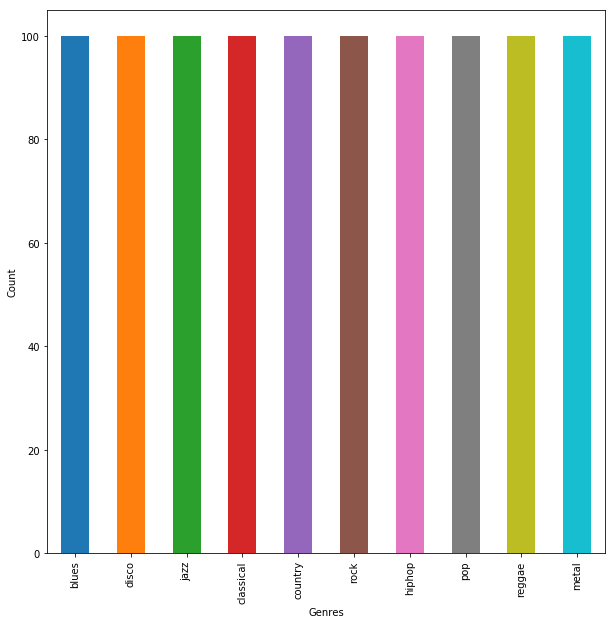

In [6]:
plt.figure(figsize=(10, 10))
data['label'].value_counts().plot(kind='bar')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.show()

### Data Analysis

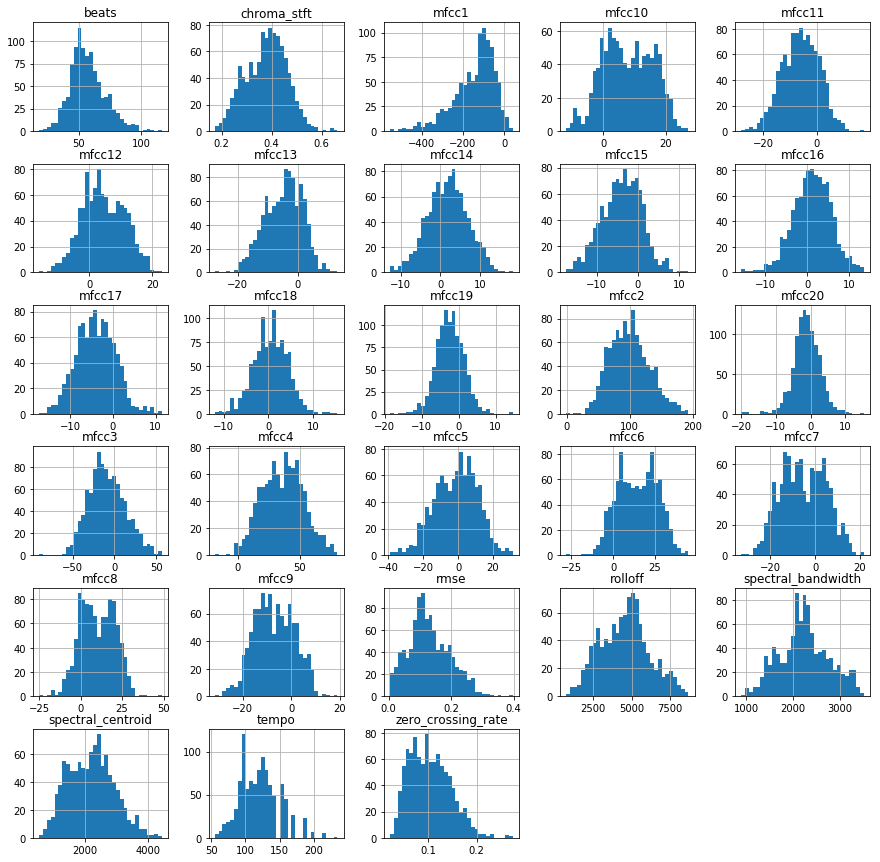

In [7]:
data.drop('label',axis=1).hist(bins=32, figsize=(15,15))
plt.show()

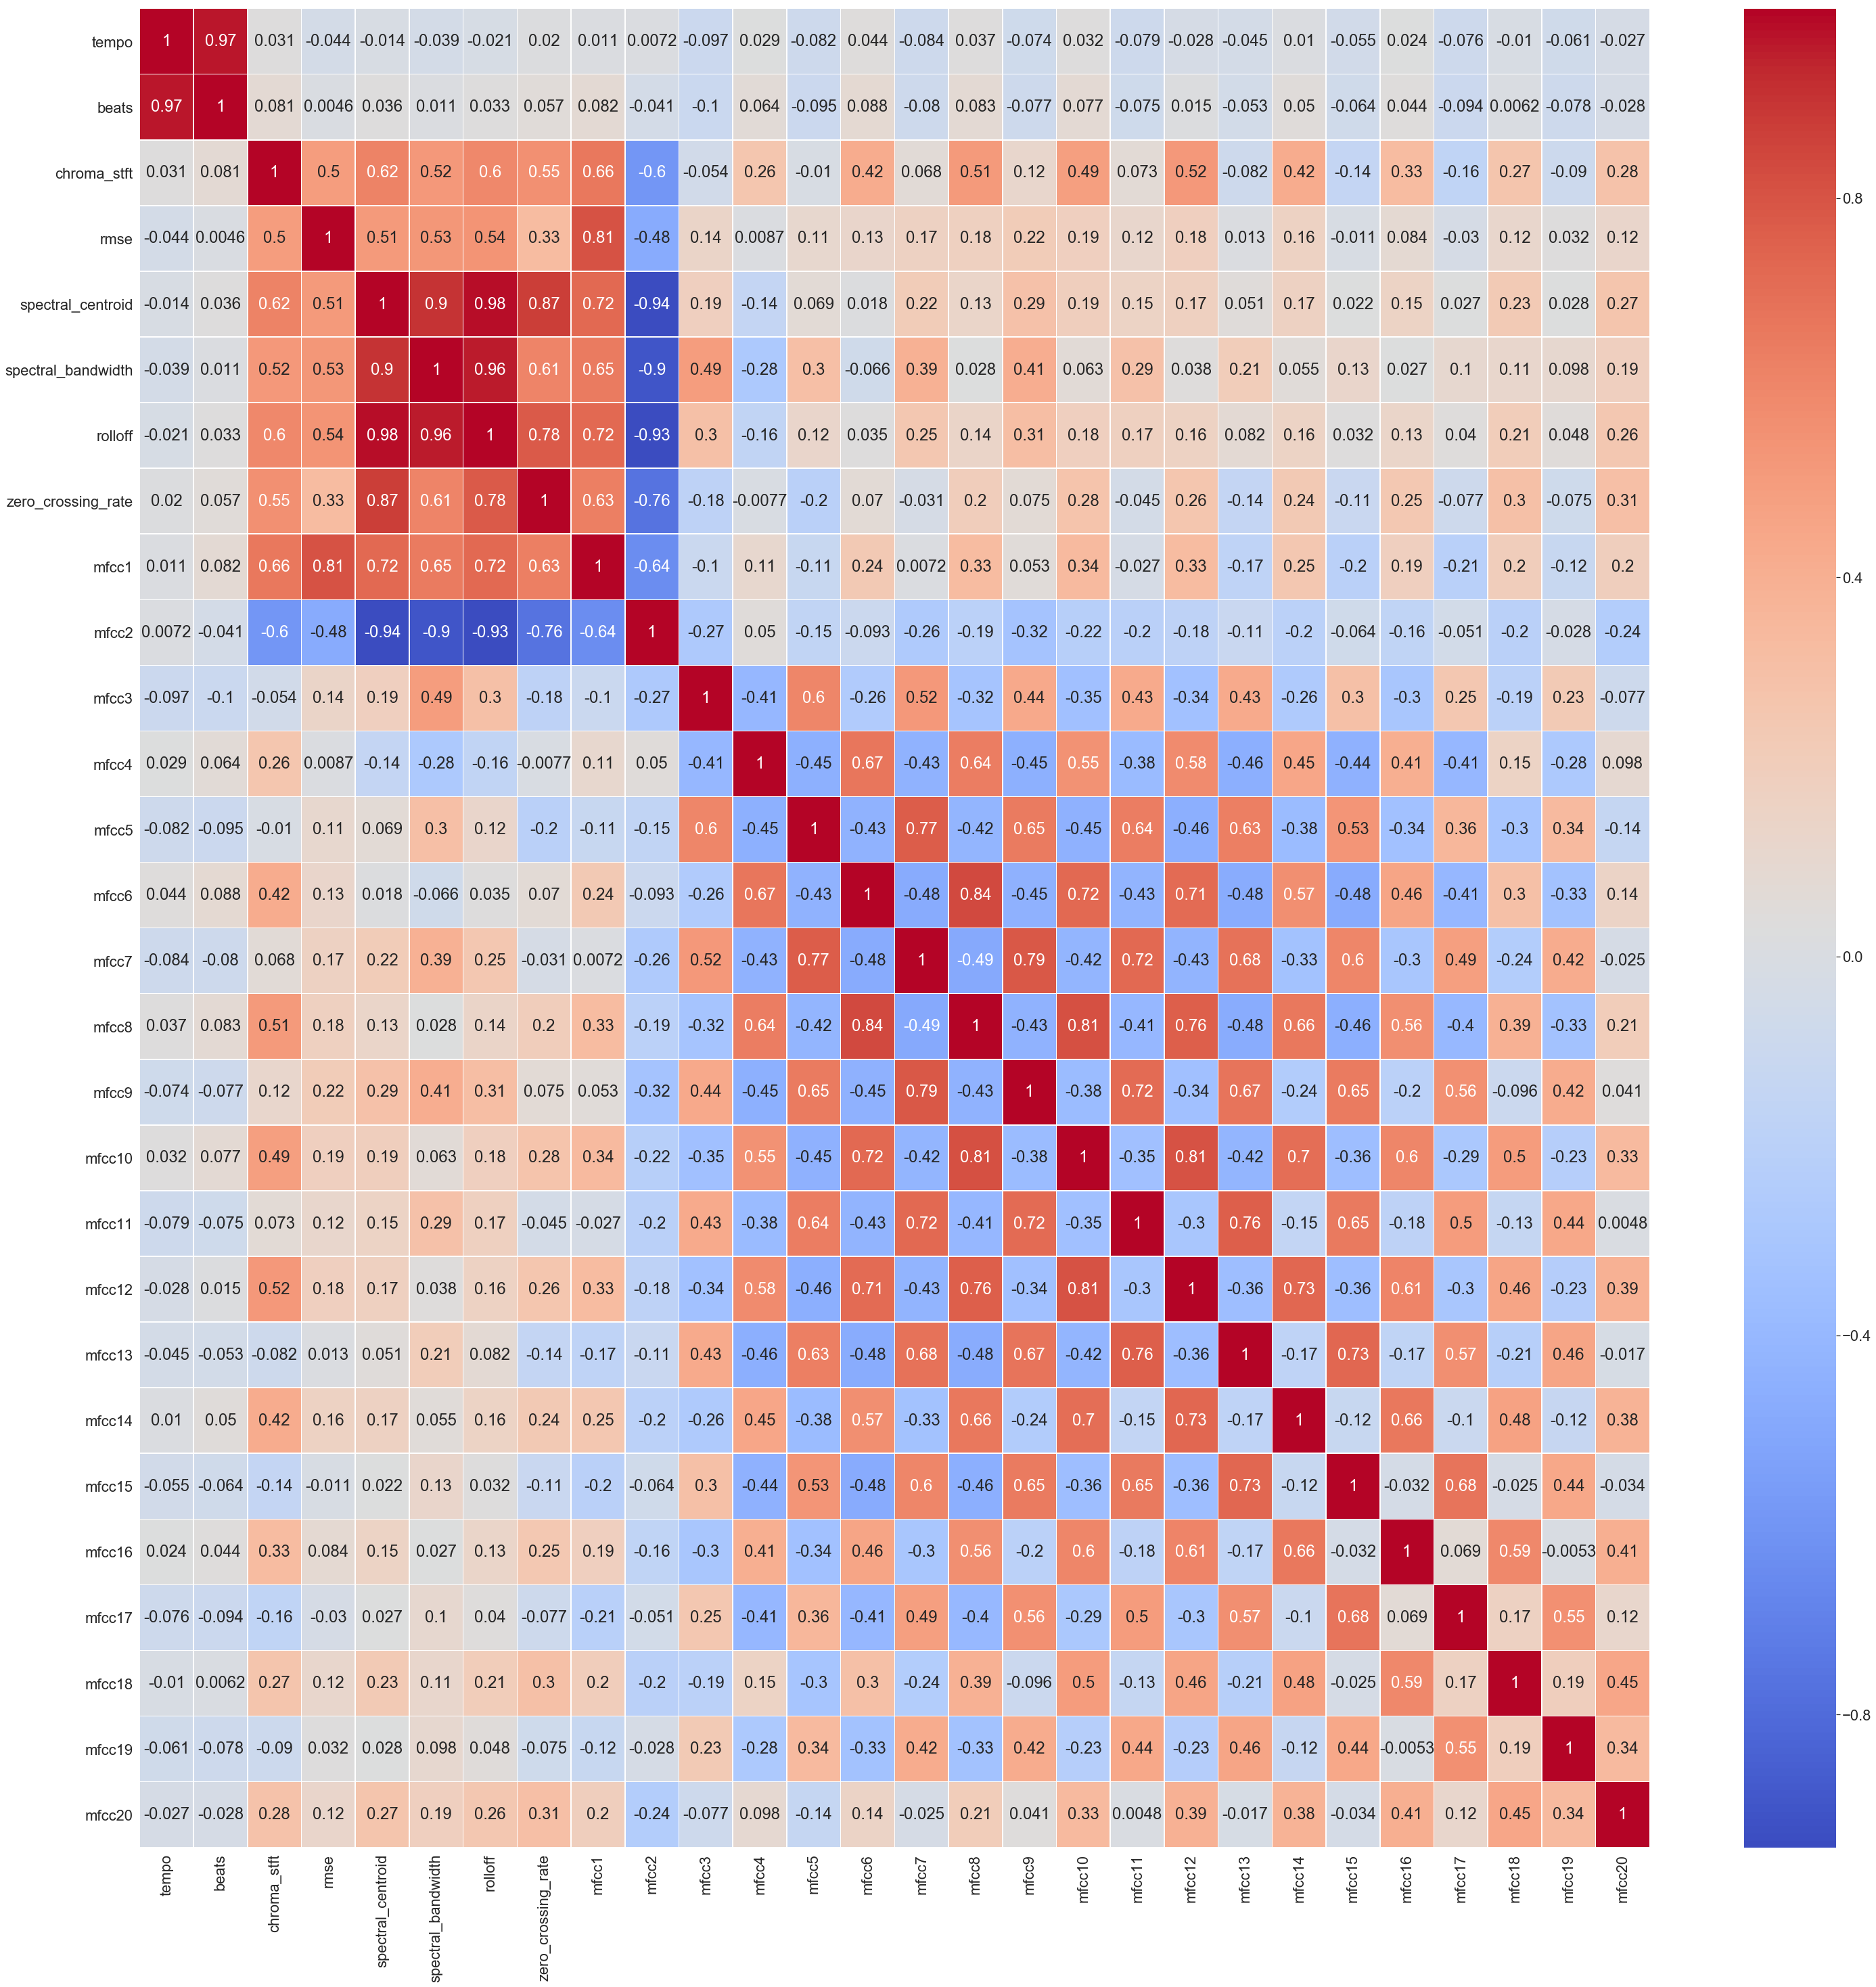

In [8]:
import seaborn as sns
plt.figure(figsize=(50,50))
sns.set(font_scale = 2)
sns.heatmap(data.corr(), annot=True, linewidth=0.5, cmap='coolwarm')

In [9]:
def genre_to_onehot(genre):
    array = np.zeros(len(genres), dtype=np.float32)
    array[genre_to_int(genre)] = 1
    return array

In [10]:
def genre_to_int(genre):
    return genres.index(genre)

In [11]:
data['one_hot_label'] = data.apply(lambda row: genre_to_onehot(row['label']), axis=1)
data.head()

,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label,one_hot_label
0,blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,...,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,...,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,...,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,...,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,...,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [12]:
min_max_scaler = preprocessing.MinMaxScaler()

x_columns = ['tempo', 'beats', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate',
             'mfcc1', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']

x_train, x_test, y_train_labels, y_test_labels = train_test_split(data[x_columns], data[['label']], stratify=data[['label']], test_size=0.25)

x_train = min_max_scaler.fit_transform(x_train.as_matrix())
x_test = min_max_scaler.fit_transform(x_test.as_matrix())

/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [13]:
x_train.shape

(750, 18)

In [14]:
x_test.shape

(250, 18)

In [15]:
x_test

array([[0.71428571, 0.6741573 , 0.57545125, ..., 0.36438391, 0.20845851,
        0.39187911],
       [0.33333333, 0.31460674, 0.45794345, ..., 0.63873772, 0.27209541,
        0.51233387],
       [0.71428571, 0.74157303, 0.27281972, ..., 0.82018135, 0.27580983,
        0.5930511 ],
       ...,
       [0.33333333, 0.30337079, 0.55935981, ..., 0.53993888, 0.27694537,
        0.45497087],
       [0.27777778, 0.29213483, 0.70463415, ..., 0.64515059, 0.3186109 ,
        0.89213906],
       [0.64444444, 0.62921348, 0.56519623, ..., 0.42444386, 0.40602565,
        0.18751913]])

In [16]:
# One-hot-encoding
y_test = []

#print(y_test_labels)
for index, row in y_test_labels.iterrows():
    y_test.append(genre_to_onehot(row['label']))
    
y_test = np.array(y_test)

y_train = []

#print(y_test_labels)
for index, row in y_train_labels.iterrows():
    y_train.append(genre_to_onehot(row['label']))
    
y_train = np.array(y_train)


In [17]:
model = tf.keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(tf.keras.layers.Dense(18, activation='relu'))
# Add another:
model.add(tf.keras.layers.Dense(64, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
history = model.fit(x_train, y_train, epochs=100, batch_size=16, validation_split=0.1)

Train on 675 samples, validate on 75 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
675/675 [==============================] - 0s 615us/sample - loss: 2.2892 - acc: 0.1467 - val_loss: 2.2724 - val_acc: 0.2533
Epoch 2/100
675/675 [==============================] - 0s 157us/sample - loss: 2.2227 - acc: 0.2830 - val_loss: 2.2248 - val_acc: 0.2400
Epoch 3/100
675/675 [==============================] - 0s 154us/sample - loss: 2.1543 - acc: 0.2978 - val_loss: 2.1619 - val_acc: 0.2267
Epoch 4/100
675/675 [==============================] - 0s 145us/sample - loss: 2.0673 - acc: 0.2933 - val_loss: 2.0826 - val_acc: 0.2533
Epoch 5/100
675/675 [==============================] - 0s 138us/sample - loss: 1.9657 - acc: 0.3007 - val_loss: 2.0144 - val_acc: 0.2667
Epoch 6/100
675/675 [==============================] - 0s 138us/sample - loss: 1.8812 - acc: 0.3244 - val_loss: 1.9421 - val_acc: 0.2400
Epoch 7/100
675/675 [==============================] - 0s 161us/sample - loss: 1.8140

675/675 [==============================] - 0s 131us/sample - loss: 1.2930 - acc: 0.5215 - val_loss: 1.5274 - val_acc: 0.4000
Epoch 59/100
675/675 [==============================] - 0s 131us/sample - loss: 1.2971 - acc: 0.5170 - val_loss: 1.5451 - val_acc: 0.3867
Epoch 60/100
675/675 [==============================] - 0s 131us/sample - loss: 1.2905 - acc: 0.5111 - val_loss: 1.5445 - val_acc: 0.3867
Epoch 61/100
675/675 [==============================] - 0s 129us/sample - loss: 1.2796 - acc: 0.5393 - val_loss: 1.5309 - val_acc: 0.3867
Epoch 62/100
675/675 [==============================] - 0s 132us/sample - loss: 1.2853 - acc: 0.5230 - val_loss: 1.5236 - val_acc: 0.4267
Epoch 63/100
675/675 [==============================] - 0s 145us/sample - loss: 1.2778 - acc: 0.5259 - val_loss: 1.5249 - val_acc: 0.3600
Epoch 64/100
675/675 [==============================] - 0s 133us/sample - loss: 1.2807 - acc: 0.5348 - val_loss: 1.5218 - val_acc: 0.4000
Epoch 65/100
675/675 [=========================

In [20]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.452


Text(0,0.5,'loss')

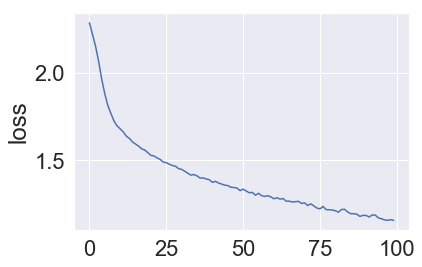

In [21]:
plt.plot(history.history['loss'])
plt.ylabel('loss')